# Práctica 4a: Selección de características numéricas

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
# Cargamos el dataset
df = pd.read_csv('heart.csv')
df["MEDV"] = df.target
df= df.drop("target",1)
X = df.drop("MEDV",1)   #Características
y = df["MEDV"]          #Target
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,MEDV
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


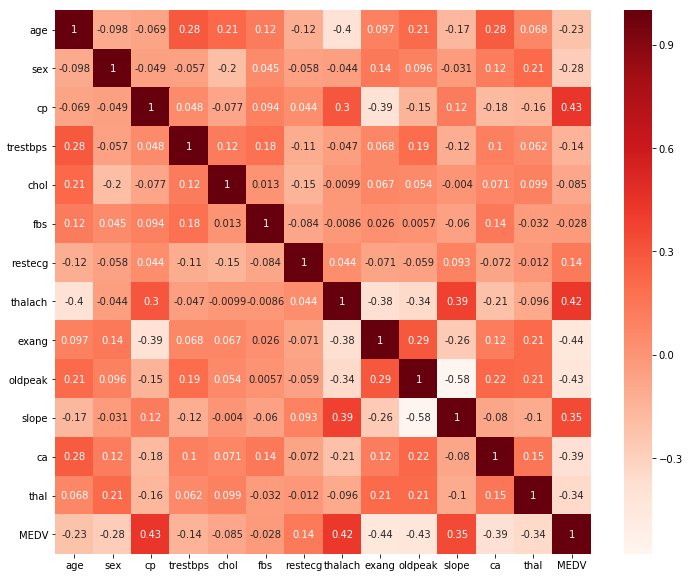

In [3]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["MEDV"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.4]
relevant_features

cp         0.433798
thalach    0.421741
exang      0.436757
oldpeak    0.430696
MEDV       1.000000
Name: MEDV, dtype: float64

Como podemos ver, sólo las características `cp`, `thalach` ,`oldpeak` " `exang` están altamente correlacionadas con la variable target `MEDV`. Por lo tanto, ignoraremos las demás características. Sin embargo, este no es el final del proceso. Una de las suposiciones de la regresión lineal es que las variables independientes necesitan ser descorrelacionadas entre sí. Es decir, si estas variables están correlacionadas entre sí, entonces necesitamos mantener sólo una de ellas y eliminar el resto. Así que vamos a comprobar la correlación de las características seleccionadas entre sí. Esto se puede hacer ya sea comprobando visualmente desde la matriz de correlación de arriba o desde el fragmento de código de abajo.

In [5]:
print(df[["cp","thalach","oldpeak","exang"]].corr())

               cp   thalach   oldpeak     exang
cp       1.000000  0.295762 -0.149230 -0.394280
thalach  0.295762  1.000000 -0.344187 -0.378812
oldpeak -0.149230 -0.344187  1.000000  0.288223
exang   -0.394280 -0.378812  0.288223  1.000000


Del código anterior, se ve que las variables no estan correlacionadas porque no superan el umbral de .4

### Wrapper Method

El "método de envoltura" necesita un algoritmo de aprendizaje automático y utiliza su rendimiento como criterio de evaluación. Esto significa que se alimentan las funciones al algoritmo de aprendizaje automático seleccionado y, en función del rendimiento del modelo, se añaden o eliminan funciones. Se trata de un proceso iterativo y costoso desde el punto de vista computacional, pero es más preciso que el método de filtrado.
Existen diferentes métodos de envoltura como la eliminación hacia atrás (Backward Elimination), la selección hacia adelante (Forward Selection), la eliminación bidireccional (Bidirectional Elimination) y la eliminación recursiva de características RFE. Discutiremos la eliminación hacia atrás y RFE aquí.

#### Backward Elimination

Al principio alimentamos el modelo con todas las características posibles, comprobamos el rendimiento del modelo y luego eliminamos las características de peor rendimiento una por una hasta que el rendimiento total del modelo se encuentre en un rango aceptable.
La métrica de rendimiento utilizada aquí para evaluar el rendimiento de las características es `pvalue`. Si el valor `p` **es superior** a `0.05`, entonces eliminamos la característica, de otro modo la mantenemos.
Primero ejecutaremos una iteración aquí sólo para tener una idea del concepto y luego ejecutaremos el mismo código en un bucle, lo que dará el conjunto final de características. Aquí estamos usando el modelo `OLS` que significa "Ordinary Least Squares". Este modelo se utiliza para realizar una regresión lineal.

In [6]:
#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


fbs         7.711245e-01
age         7.611292e-01
chol        4.025451e-01
restecg     2.128192e-01
trestbps    1.144073e-01
slope       6.345322e-02
oldpeak     1.084749e-02
thalach     7.988188e-03
exang       5.386779e-03
const       4.986501e-03
thal        9.523132e-04
sex         4.244938e-05
ca          6.248649e-06
cp          8.401461e-07
dtype: float64

Como vemos, la variable `AGE` tiene el valor p más alto de `0.9582293` que es mayor que 0.05. Por lo tanto, eliminaremos esta característica y construiremos el modelo una vez más. Este es un proceso iterativo y puede realizarse de una sola vez con la ayuda del bucle. Este enfoque se implementa a continuación, lo que daría el conjunto final de variables que son `CRIM`, `ZN`, `CHAS`, `NOX`, `RM`, `DIS`, `RAD`, `TAX`, `PTRATIO`, `B` y `LSTAT`.

In [7]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


#### Recursive Feature Elimination (RFE)

El método recursivo de eliminación de características (RFE) funciona mediante la eliminación recursiva de atributos y la construcción de un modelo sobre los atributos que quedan. Utiliza una métrica de precisión para clasificar la característica según su importancia. El método RFE toma como entrada el modelo a ser utilizado y el número de características requeridas. A continuación, proporciona la clasificación de todas las variables, siendo `1` la más importante y en descendencia las menos importantes; viéndolo de forma más concisa, `True` la característica relevante y `False` la característica irrelevante.

In [8]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[False  True  True False False False False False  True  True  True  True
  True]
[6 1 1 5 7 4 2 3 1 1 1 1 1]


Aquí tomamos el modelo `LinearRegression` con 7 características y RFE dio la clasificación de características como arriba, pero la selección del número '7' fue aleatoria, pudimos haber puesto '3' u '11'. Ahora necesitamos encontrar este número óptimo de características, para las cuales la precisión es la más alta. Esto lo hacemos usando el bucle que empieza con 1 característica y sube hasta 13. Luego tomamos la característica para la cual la precisión es más alta.

In [9]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 11
Desempeño con 11 características: 0.435197


Como se ve en el código anterior, el número óptimo de características es 10. Ahora alimentamos 10 como número de características a RFE y obtenemos el conjunto final de características dadas por el método RFE.

In [10]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['sex', 'cp', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


### Embedded Method

Los métodos integrados se ocupa de cada iteración del proceso de entrenamiento del modelo y extrae cuidadosamente las características que más contribuyen al entrenamiento para una iteración en particular. Los métodos de **regularización** son los métodos integrados más utilizados, ya que penalizan una característica dado un umbral. Entonces haremos la selección de características mediante un método integrado, usando la regularización de Lasso:
> "Si la característica es irrelevante, Lasso penaliza su peso y lo convierte en 0. Por lo tanto, los rasgos con peso = 0 se eliminan y el resto se toman."

In [11]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Número óptimo de características:12
Desempeño mediante la regularización Lasso: 0.516022


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

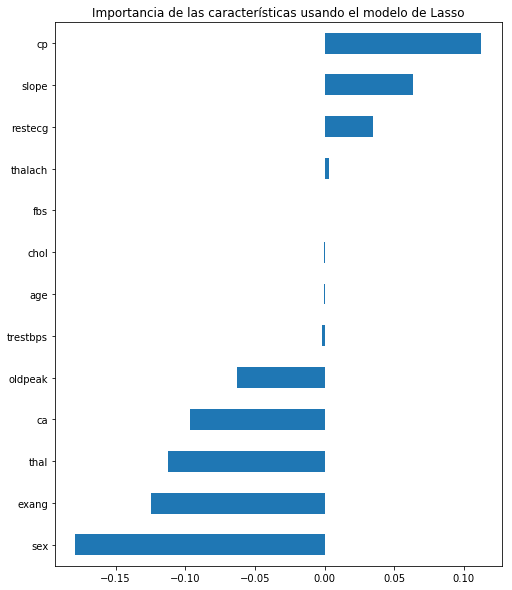

In [12]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")

Aquí la regularización Lasso ha tomado todas las características excepto `fbs`